In [23]:
import numpy as np
from scipy import linalg, io, sparse
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from optfunctions import *

In [24]:
#ONLY RUN IF GUROBI IS INSTALLED!
import gurobipy as gp
from gurobipy import GRB

solve system of form:

$\underset{x}{\mathrm{min}}\quad \frac{1}{2}x^\top H x + g^\top x$

$l \leq x \leq u,\\ d_l \leq C^\top x \leq d_u$

In [25]:
#load data from file:
data = io.loadmat("QP_Test.mat")

#preprocess to get correct shape and dtypes:
H = data["H"]
g = data["g"].ravel()
C = data["C"].astype(np.float64)
dl = data["dl"].ravel()
du = data["du"].ravel()
l = data["l"].ravel().astype(np.float64)
u = data["u"].ravel().astype(np.float64)

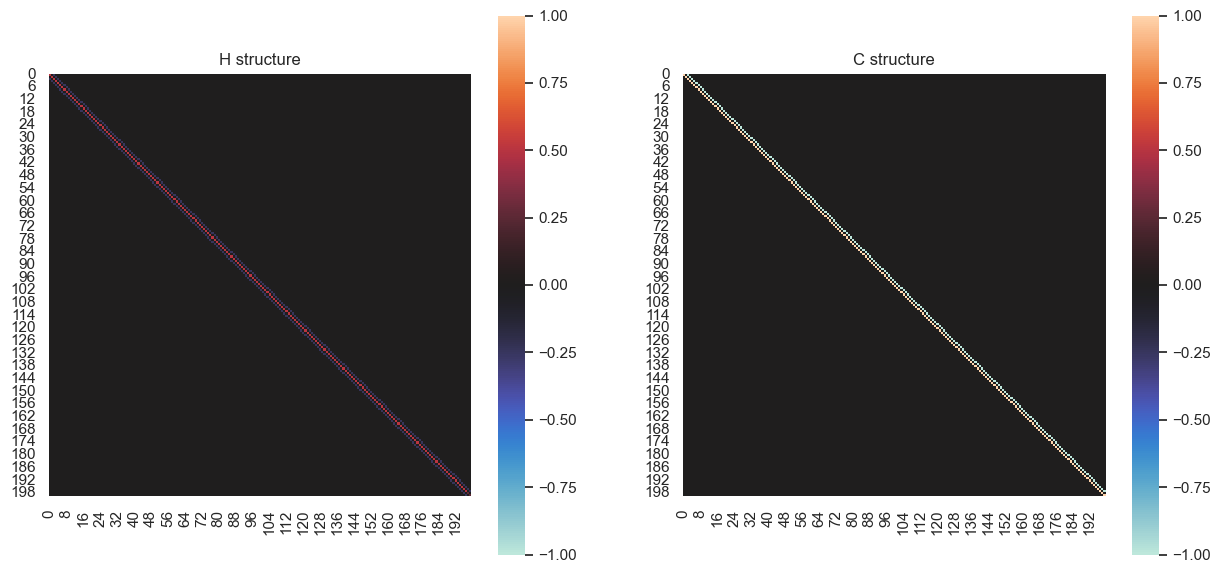

In [26]:
#plot structures of H and C:
fig, axs = plt.subplots(1,2,figsize=(15,7))

sns.heatmap(H, ax=axs[0], square=True, vmin=-1, vmax=1, cmap="icefire")
axs[0].set_title("H structure")

sns.heatmap(C, ax=axs[1], square=True, vmin=-1, vmax=1, cmap="icefire")
axs[1].set_title("C structure")

plt.show()

**This indicates potential use of sparse solvers**

## PART 1.4
### Solve problem using available solver packages:

In [27]:
#ONLY RUN CELL IF GUROBI IS INSTALLED!
m = gp.Model("part2")   #define model 

x = m.addMVar(shape=len(g), vtype=GRB.CONTINUOUS,name="x",lb=l,ub=u)    #add optimization variables with lower and upper bound 

cl = m.addConstr(C.T @ x >= dl, name="lb")  #add lower bound inequality constraints
cl = m.addConstr(-C.T @ x >= -du, name="ub")    #add upper bound inequality constraints

m.setObjective((1/2)*x.T @ H @ x + g.T @ x, GRB.MINIMIZE)   #set model objective

m.optimize()    #optimize the model


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 9 5900HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 200 columns and 796 nonzeros
Model fingerprint: 0x93b191d3
Model has 20100 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 3e+01]
  QObjective range [3e-07, 5e-01]
  Bounds range     [1e+02, 3e+02]
  RHS range        [4e+01, 2e+02]
Presolve removed 202 rows and 0 columns
Presolve time: 0.01s
Presolved: 198 rows, 397 columns, 593 nonzeros
Presolved model has 20100 quadratic objective terms
Ordering time: 0.01s

Barrier statistics:
 Free vars  : 199
 AA' NZ     : 3.999e+04
 Factor NZ  : 5.861e+04 (roughly 1 MB of memory)
 Factor Ops : 1.130e+07 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter  

In [28]:
sol_gurobi = np.array(m.x)
print(f"time: {m.Runtime}s")

time: 0.056999921798706055s


**MISSING PLOTTING THE DATA**

In [29]:
#plotting data
output_mat = io.loadmat("plot_output.mat")

headers = list(output_mat.keys())[3:]

for h in headers:
    print(f"{h} shape: {output_mat[h].shape}, dtype: {output_mat[h].dtype}")

N shape: (1, 1), dtype: uint8
u_prev shape: (2, 1), dtype: float64
ys shape: (2, 1), dtype: float64
T shape: (1, 100), dtype: float64
x_kk shape: (6, 1), dtype: float64
C shape: (2, 6), dtype: float64
A shape: (6, 6), dtype: float64
B shape: (6, 2), dtype: float64
xs shape: (4, 1), dtype: float64
ds shape: (2, 1), dtype: uint8
zs shape: (2, 1), dtype: float64
us shape: (2, 1), dtype: uint16
R_k shape: (200, 1), dtype: float64


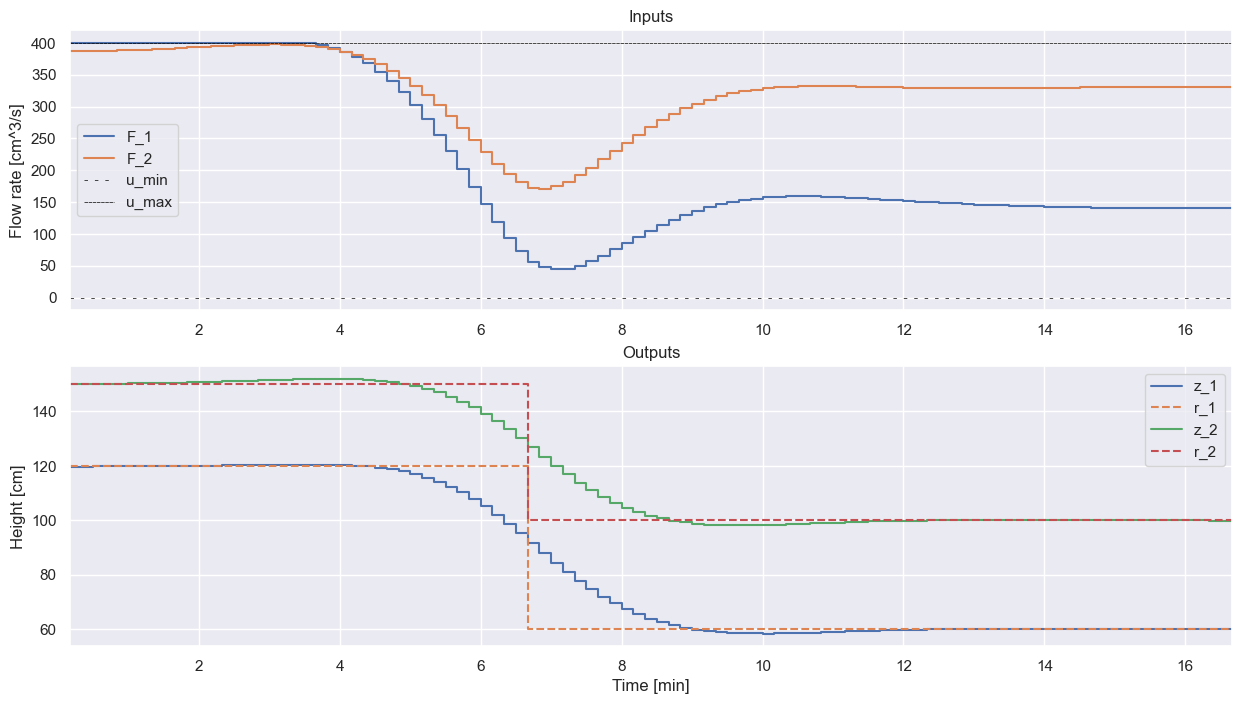

In [30]:
#replicate function in "PlotSolutionQP.m":
def plot_solution(U, data):
    mat = io.loadmat(data)
    N = mat["N"].flatten()[0]
    C = mat["C"]
    A = mat["A"]
    B = mat["B"]
    T = mat["T"].ravel()
    xx = mat["x_kk"].copy().ravel()

    u = U.reshape(100, 2)

    x = np.zeros((N,len(xx)))
    x[0] = xx
    z = np.zeros((N,2))
    z[0] = C @ xx
    for i in range(1,N):
        x[i] = A @ x[i-1] + B @ u[i-1]
        z[i] = C @ x[i]

    z = z + mat["zs"].astype(np.float64).ravel()
    u = u + mat["us"].astype(np.float64).ravel()
    r = mat["R_k"].reshape((100,2)) + mat["zs"].astype(np.float64).ravel()

    fig, ax = plt.subplots(2,1,figsize=(15,8))

    for i in range(2):
        ax[0].step(T, u[:,i], label=f"F_{i+1}")
        ax[1].step(T, z[:,i], label=f"z_{i+1}")
        ax[1].step(T, r[:,i], label=f"r_{i+1}", linestyle="--")
        ax[i].set_xlim([T.min(),T.max()])
    ax[0].axhline(y=0, label="u_min", color="black", linestyle=(0, (5, 10)), linewidth=0.5)
    ax[0].axhline(y=400, label="u_max", color="black", linestyle=(0, (5, 1)), linewidth=0.5)
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title("Inputs")
    ax[1].set_title("Outputs")
    ax[0].set_ylabel("Flow rate [cm^3/s]")
    ax[1].set_ylabel("Height [cm]")
    ax[1].set_xlabel("Time [min]")

    plt.show()

plot_solution(sol_gurobi, "plot_output.mat")

### Helper functions

Initial point solver for active set QP (potentially for others aswell):

## PART 1.5
### Implementing active-set method:

Using big M form we transform the problem into:

$\mathrm{min}\, 0.5\begin{bmatrix} x \\ t \end{bmatrix}^\top \begin{bmatrix} H & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ t \end{bmatrix} + \begin{bmatrix} g \\ M \end{bmatrix}^\top \begin{bmatrix} x \\ t \end{bmatrix}$

st.      $\begin{bmatrix} A & 1 \\ 0 & 1 \end{bmatrix} \geq \begin{bmatrix} b \\ 0 \end{bmatrix}$

Primal Active set algorithm for convex QP:

In [31]:
sol_act, xks_act, lks_act, wks, iter_act, converged_act = active_set(H, g, C, dl, du, l, u, 
                                                                     max_iter=1000,  tol=1e-8, 
                                                                     solver="LUdense", verbose=False)

solved successfully with M = 4
    solved in 0.032415299996500835s,
    and 24 iterations.
Total time: 0.06486470000527333s


In [32]:
#Compare objective values with commercial solver:
#gurobi gave objective of -49341.9075
obj_active = 0.5*sol_act[:-1].T @ H @ sol_act[:-1] + g.T @ sol_act[:-1]
print(f"Objective value of active set method: {obj_active}")

Objective value of active set method: -49341.90751270984


In [33]:
#Compare x values:
print(np.allclose(sol_gurobi,sol_act[:-1]))

True


## PART 1.8
### Implement primal-dual interior-point algorithm:

In [34]:
t1 = time.perf_counter()
sol_interior, xks, zks, sks, res, iter_interior, converged = primal_dual_interior(H,g,l,u,C,dl,du, 
                                                                                  tol=1e-14, max_iter=100)
t2 = time.perf_counter()

time_interior = t2-t1

print(f"time elapsed: {time_interior}s")
print(f"solved in {iter_interior} iterations")

time elapsed: 0.06678640000609448s
solved in 14 iterations


In [35]:
interior_obj = 0.5 * sol_interior.T @ H @ sol_interior + g.T @ sol_interior
print(f"Objective value of primal-dual interior-point algorithm: {interior_obj}")

Objective value of primal-dual interior-point algorithm: -49341.90751270502


In [36]:
#Compare x values:
print(np.allclose(sol_gurobi,sol_interior))

True


In [37]:
print(np.all(sol_interior == xks[-1]))

True


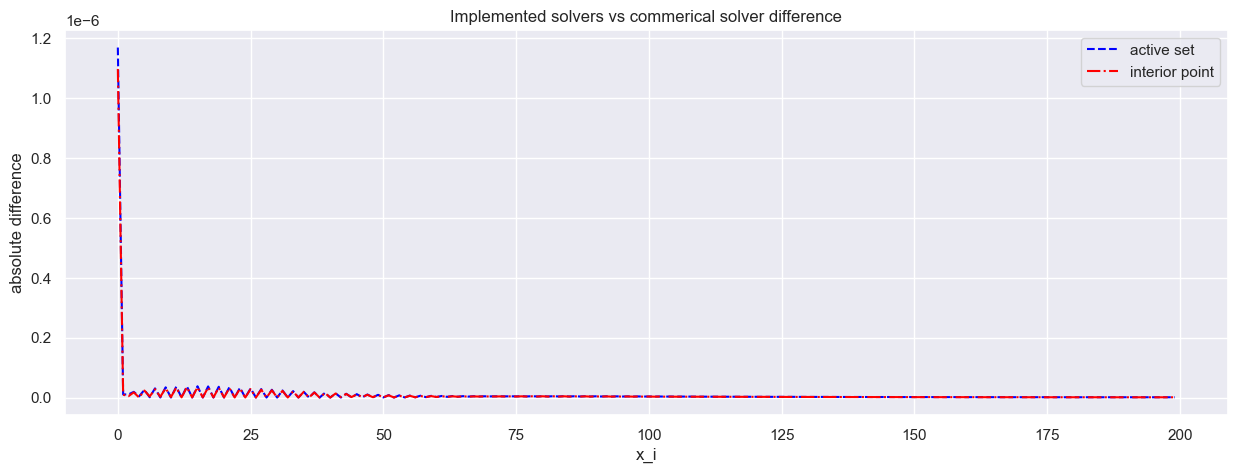

In [38]:
fig, axs = plt.subplots(figsize=(15,5))

xs = np.arange(len(g))
axs.plot(xs, np.abs(sol_act[:-1] - sol_gurobi), linestyle="dashed", color="blue", label="active set")
axs.plot(xs, np.abs(sol_interior - sol_gurobi), linestyle="-.", color="red", label="interior point")
axs.legend()
axs.set_xlabel("x_i")
axs.set_ylabel("absolute difference")
plt.title("Implemented solvers vs commerical solver difference")
plt.show()

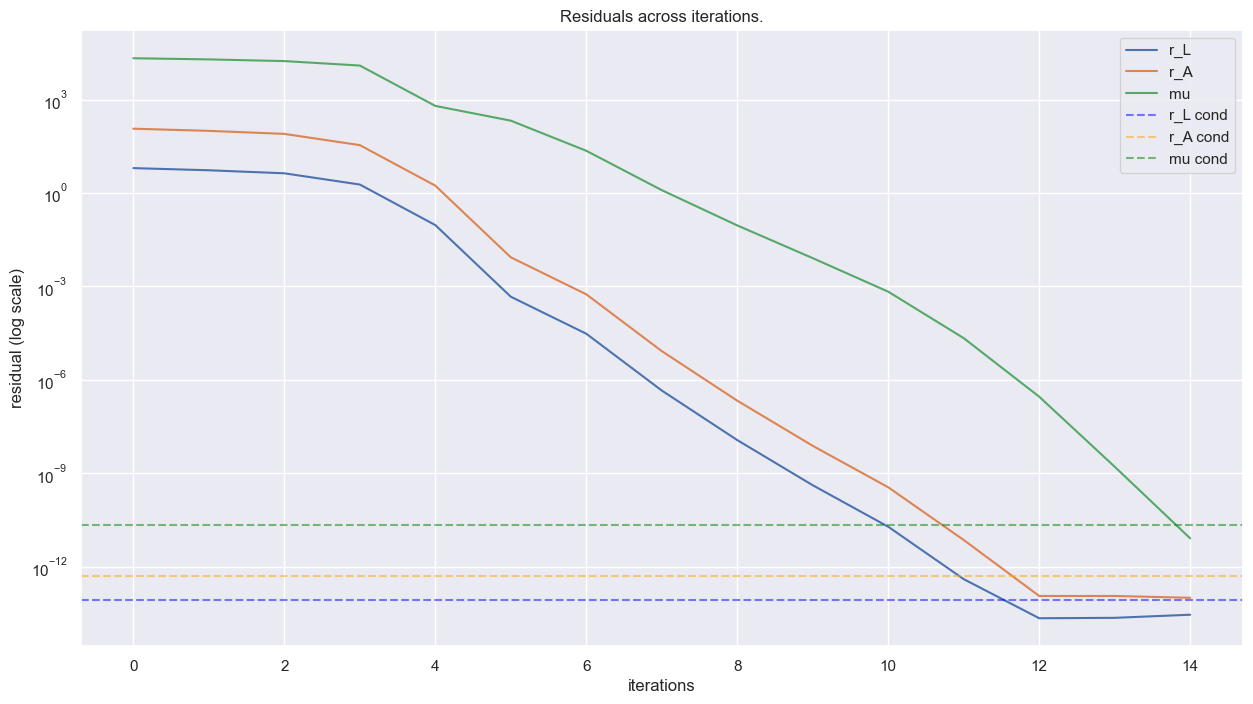

In [39]:
fig, ax = plt.subplots(figsize=(15,8))
conds = [8.6e-14, 5e-13, 2.14e-11]
ax.semilogy(np.arange(iter_interior+1), res)

ax.axhline(y=conds[0], alpha=0.5, linestyle="--", color="blue")
ax.axhline(y=conds[1], alpha=0.5, linestyle="--", color="orange")
ax.axhline(y=conds[2], alpha=0.5, linestyle="--", color="green")
ax.legend(["r_L", "r_A", "mu","r_L cond","r_A cond","mu cond"])
ax.set_xlabel("iterations")
ax.set_ylabel("residual (log scale)")
plt.title("Residuals across iterations.")
plt.show()